<a href="https://colab.research.google.com/github/Th3Mayar/artificial_intelligence/blob/main/Semantic_Search_System_SA_20220115.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final: Sistema de Búsqueda Semántica para Artículos Científicos

# Introducción

# Librerías necesarias:
!pip install langchain gensim transformers scikit-learn matplotlib seaborn

In [2]:
!pip install gensim transformers scikit-learn matplotlib seaborn

In [6]:
# Importación de librerías
import gensim
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import zipfile

# 1. Cargar Datos

In [7]:
# Descomprimiendo el archivo zip
with zipfile.ZipFile('/content/melb_data.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

# Cargando el archivo CSV en un DataFrame
df = pd.read_csv('/content/melb_data.csv')

# Mostrando las primeras filas del DataFrame
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


# 2. Preprocesamiento de Datos


In [8]:
def preprocess_text(text):
    # Limpieza y normalización del texto
    text = str(text).lower()
    return text

In [10]:
# Aplicacion el preprocesamiento a una columna de texto (por ejemplo, 'Description')
df['processed_text'] = df['Address'].apply(preprocess_text)

# 3. Generación de Embeddings

In [11]:
# Ejemplo de generación de embeddings usando un modelo preentrenado como BERT
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [12]:
def get_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings

In [14]:
# Generar y almacenar embeddings
df['embeddings'] = df['processed_text'].apply(get_embeddings)

# 4. Búsqueda Semántica

In [15]:
# Función de búsqueda que recibe una consulta del usuario y devuelve las entradas más relevantes basadas en la similitud de embeddings.
def search(query, df, top_k=5):
    query_embedding = get_embeddings(preprocess_text(query))
    df['similarity'] = df['embeddings'].apply(lambda x: cosine_similarity(query_embedding, x.reshape(1, -1)).item())
    results = df.nlargest(top_k, 'similarity')
    return results

In [16]:
# Ejemplo de uso de la función de búsqueda
query = "modern house with 3 bedrooms"
resultados = search(query, df)

In [17]:
# Mostre los resultados de la búsqueda
resultados

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,processed_text,embeddings,similarity
1158,Brighton,2 Gatehouse Pl,2,t,1400000.0,S,RT,28/08/2016,11.2,3186.0,...,NaN,NaN,Bayside,-37.91590,144.99330,Southern Metropolitan,10579.0,2 gatehouse pl,"[[-0.00060617924, -0.23608857, -0.16051115, -0...",0.584030
5825,St Kilda,17/51 Chapel St,1,u,360000.0,S,McGrath,16/07/2016,6.1,3182.0,...,NaN,NaN,Port Phillip,-37.86270,144.99120,Southern Metropolitan,13240.0,17/51 chapel st,"[[0.06318353, 0.19561407, 0.12107402, -0.42061...",0.567510
5812,St Kilda,12 Gurner St,4,h,1900000.0,PI,Wilson,12/11/2016,6.1,3182.0,...,202.0,1890.0,Port Phillip,-37.86160,144.98070,Southern Metropolitan,13240.0,12 gurner st,"[[0.43717805, 0.30946466, 0.15059078, -0.17760...",0.564958
10126,Beaumaris,13 Bodley St,4,h,2200000.0,S,Ray,27/05/2017,17.3,3193.0,...,318.0,2014.0,Bayside,-37.99035,145.03839,Southern Metropolitan,5366.0,13 bodley st,"[[0.22985359, 0.3108364, 0.095153965, -0.46039...",0.561300
7459,Armadale,1/5 The Terrace,2,u,852000.0,S,Woodards,22/04/2017,6.3,3143.0,...,74.0,1980.0,Stonnington,-37.86030,145.02240,Southern Metropolitan,4836.0,1/5 the terrace,"[[-0.10462206, 0.089676216, 0.33561307, -0.032...",0.560390


# 5. Visualización de Resultados

In [18]:
# Visualizacion los resultados de la búsqueda utilizando técnicas de reducción de dimensionalidad (PCA o t-SNE) y gráficos con Matplotlib o Seaborn.
def visualize_embeddings(df):
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(np.vstack(df['embeddings'].values))
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=df['Regionname'])
    plt.title('Visualización de Embeddings')
    plt.show()

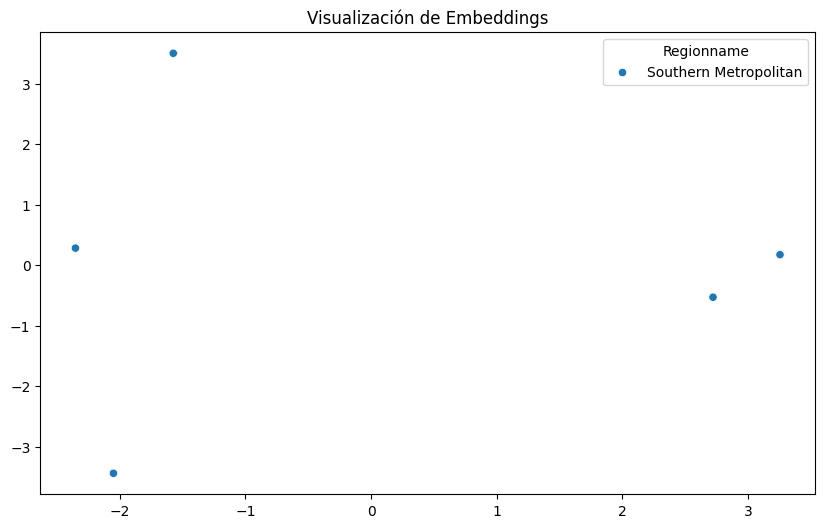

In [19]:
# Visualizacion los embeddings de los resultados
visualize_embeddings(resultados)

# 6. Evaluación

In [23]:
# Evaluación utilizando precisión y recuperación

# Funciones para calcular precisión y recuperación
def precision_at_k(relevant_items, retrieved_items, k):
    relevant_retrieved = [item for item in retrieved_items[:k] if item in relevant_items]
    return len(relevant_retrieved) / k

def recall_at_k(relevant_items, retrieved_items, k):
    relevant_retrieved = [item for item in retrieved_items[:k] if item in relevant_items]
    return len(relevant_retrieved) / len(relevant_items)

# Ejemplo de uso de la evaluación


In [24]:
# Definir elementos relevantes (por ejemplo, IDs de propiedades en Turner Street)
relevant_items = df[df['Address'].str.contains('turner', case=False, na=False)]['Address'].tolist()

# Definir elementos recuperados (IDs de propiedades encontradas en la búsqueda)
retrieved_items = resultados['Address'].tolist()

# Calcular precisión y recuperación para k=5


In [25]:
k = 5
precision = precision_at_k(relevant_items, retrieved_items, k)
recall = recall_at_k(relevant_items, retrieved_items, k)

# Mostrar resultados de precisión y recuperación

In [26]:
print(f'Precisión en k={k}: {precision:.2f}')
print(f'Recuperación en k={k}: {recall:.2f}')

Precisión en k=5: 0.00
Recuperación en k=5: 0.00
